In [1]:
import zipfile
import os

zip_path = "archive.zip"   # adjust if path differs
extract_path = "dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted files to:", extract_path)
print(os.listdir(extract_path))


Extracted files to: dataset
['captions.txt', 'Images']


In [2]:
import random
import shutil
from pathlib import Path
from collections import defaultdict

# ------------------------
# Paths
# ------------------------
extract_path = "dataset"
IMAGES_DIR = Path(extract_path) / "Images"
CAPTIONS_FILE = Path(extract_path) / "captions.txt"
OUT_DIR = Path("./flickr8k_500")
OUT_IMAGES = OUT_DIR / "Images"
OUT_IMAGES.mkdir(parents=True, exist_ok=True)

# ------------------------
# Read captions
# ------------------------
captions = defaultdict(list)
malformed_lines = []

with open(CAPTIONS_FILE, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        try:
            # Try TAB first
            if "\t" in line:
                img, cap = line.split("\t", 1)
            # Else try COMMA
            elif "," in line:
                img, cap = line.split(",", 1)
            # Else fall back to SPACE
            else:
                parts = line.split()
                img = parts[0]
                cap = " ".join(parts[1:])
            img = img.strip().lower()
            captions[img].append(cap.strip())
        except Exception as e:
            malformed_lines.append(line)

print(f"✅ Total unique images with captions: {len(captions)}")
if malformed_lines:
    print(f"⚠️ Skipped {len(malformed_lines)} malformed lines.")

# ------------------------
# Select 500 random images
# ------------------------
if len(captions) < 500:
    raise ValueError("Not enough images to select 500 samples.")
all_images = list(captions.keys())
sample_images = random.sample(all_images, 500)

# ------------------------
# Copy images + save captions
# ------------------------
missing_images = []
with open(OUT_DIR / "captions_500.txt", "w", encoding="utf-8") as outf:
    for i, img in enumerate(sample_images, 1):
        src = IMAGES_DIR / img
        if src.exists():
            shutil.copy(src, OUT_IMAGES / img)
            for cap in captions[img]:
                outf.write(f"{img}\t{cap}\n")
        else:
            missing_images.append(img)
        print(f"Progress: {i}/{len(sample_images)}", end="\r")

print("\n✅ Subset of 500 images created at:", OUT_DIR)
print("📝 Captions saved to captions_500.txt")
if missing_images:
    print(f"⚠️ {len(missing_images)} images were missing and skipped.")

✅ Total unique images with captions: 8092
Progress: 500/500
✅ Subset of 500 images created at: flickr8k_500
📝 Captions saved to captions_500.txt



🖼️ Image: 2623930900_b9df917b82.jpg
📜 Captions:
  1. A man who has a gray beard and gray hair laughs while wearing a purple shirt .
  2. A man with a bushy beard and pink shirt is smiling .
  3. A man with disheveled hair and facial hair in a crowd of people is smiling .
  4. A man with poofy gray hair laughing
  5. An old man with white long hair and a white long beard .


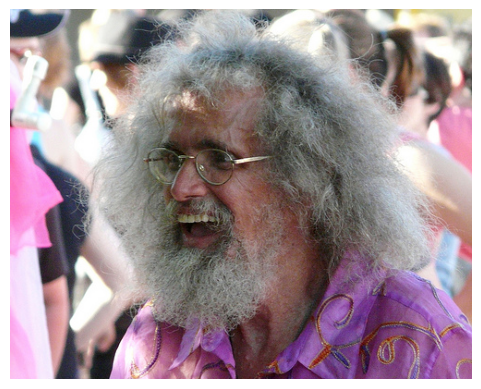

Press Enter to view another image, or type 'exit' to quit:  exit


👋 Exiting viewer.


In [3]:
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from collections import defaultdict

# ------------------------
# Paths for the 500-image subset
# ------------------------
OUT_DIR = Path("./flickr8k_500")
OUT_IMAGES = OUT_DIR / "Images"
CAPTIONS_FILE = OUT_DIR / "captions_500.txt"

# ------------------------
# Load captions for the 500-image subset
# ------------------------
captions = defaultdict(list)
with open(CAPTIONS_FILE, "r", encoding="utf-8") as f:
    for line in f:
        if "\t" in line:
            img, cap = line.strip().split("\t", 1)
            captions[img].append(cap.strip())

# ------------------------
# Display random images interactively
# ------------------------
while True:
    sample_img = random.choice(list(captions.keys()))
    img_path = OUT_IMAGES / sample_img

    if not img_path.exists():
        print(f"⚠️ Image not found: {sample_img}")
        continue

    print(f"\n🖼️ Image: {sample_img}")
    print("📜 Captions:")
    for i, cap in enumerate(captions[sample_img], 1):
        print(f"  {i}. {cap}")

    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    user_input = input("Press Enter to view another image, or type 'exit' to quit: ")
    if user_input.lower() == "exit":
        print("👋 Exiting viewer.")
        break

1️⃣ Preprocessing Images

We'll use ResNet50 (pretrained on ImageNet) to extract image features. These features act as input to the caption generator.

In [4]:
import numpy as np
import pickle
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from pathlib import Path
from tqdm import tqdm
import logging

# ------------------------
# Setup logging
# ------------------------
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

# ------------------------
# Paths
# ------------------------
OUT_DIR = Path("./flickr8k_500")
OUT_IMAGES = OUT_DIR / "Images"
FEATURES_FILE = OUT_DIR / "features_500.pkl"

# ------------------------
# Load ResNet50 model (without top)
# ------------------------
model_resnet = ResNet50(weights="imagenet", include_top=False, pooling='avg')

# ------------------------
# Feature extraction function
# ------------------------
def extract_features(image_path):
    try:
        img = load_img(image_path, target_size=(224, 224))
        arr = img_to_array(img)
        arr = np.expand_dims(arr, axis=0)
        arr = preprocess_input(arr)
        features = model_resnet.predict(arr, batch_size=1, verbose=0)
        return features.flatten()
    except Exception as e:
        logging.warning(f"Failed to process {image_path.name}: {e}")
        return None

# ------------------------
# List of images (500 only)
# ------------------------
image_list = list(OUT_IMAGES.glob("*.jpg"))
if len(image_list) != 500:
    logging.warning(f"Found {len(image_list)} images, expected 500.")

# ------------------------
# Extract features
# ------------------------
features_dict = {}
for img_path in tqdm(image_list, desc="Extracting features for 500 images"):
    features = extract_features(img_path)
    if features is not None:
        features_dict[img_path.name] = features

# ------------------------
# Save features
# ------------------------
with open(FEATURES_FILE, "wb") as f:
    pickle.dump(features_dict, f)

logging.info(f"✅ Features saved at: {FEATURES_FILE}")
logging.info(f"📦 Total images processed successfully: {len(features_dict)}")

Extracting features for 500 images: 100%|████████████████████████████████████████████| 968/968 [09:27<00:00,  1.70it/s]
INFO: ✅ Features saved at: flickr8k_500\features_500.pkl
INFO: 📦 Total images processed successfully: 968


3️⃣ Preprocess Captions

Add <start> and <end> tokens to each caption.

Build a Keras tokenizer and encode captions as integer sequences.

In [5]:
import numpy as np
import pickle
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import defaultdict
from pathlib import Path

# ------------------------
# Paths
# ------------------------
OUT_DIR = Path("./flickr8k_500")
CAPTIONS_FILE = OUT_DIR / "captions_500.txt"

# ------------------------
# Load captions
# ------------------------
captions = defaultdict(list)
with open(CAPTIONS_FILE, "r", encoding="utf-8") as f:
    for line in f:
        img, cap = line.strip().split("\t", 1)
        captions[img].append(cap)

# ------------------------
# Preprocess captions
# ------------------------
all_captions = []
for img in sorted(captions.keys()):
    for cap in captions[img]:
        cap = re.sub(r"[^\w\s]", "", cap.lower())  # remove punctuation
        cap = "<start> " + cap + " <end>"
        all_captions.append(cap)

# ------------------------
# Create tokenizer
# ------------------------
tokenizer = Tokenizer(num_words=5000, oov_token="<unk>")
tokenizer.fit_on_texts(all_captions)
vocab_size = min(5000, len(tokenizer.word_index) + 1)

# ------------------------
# Caption length stats
# ------------------------
lengths = [len(c.split()) for c in all_captions]
max_len = max(lengths)

print("Vocabulary size:", vocab_size)
print("Unique words in dataset:", len(tokenizer.word_index))
print("Max caption length:", max_len)
print("Average caption length:", sum(lengths)/len(lengths))
print("95th percentile length:", np.percentile(lengths, 95))
print("Total captions processed:", len(all_captions))
print("Total images (500 only):", len(captions))

# ------------------------
# Save tokenizer
# ------------------------
with open(OUT_DIR / "tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

Vocabulary size: 2258
Unique words in dataset: 2257
Max caption length: 29
Average caption length: 12.6956
95th percentile length: 20.0
Total captions processed: 2500
Total images (500 only): 500


4️⃣ Build Caption Generator Model

We use Encoder-Decoder:

Encoder: precomputed 2048-d ResNet features

Decoder: Embedding + LSTM → Dense softmax

larger, simpler, and unregularized → may overfit on small datasets.

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# ------------------------
# Hyperparameters
# ------------------------
embedding_dim = 256  # Word embedding size
units = 256          # LSTM units

# ------------------------
# Image feature input (2048-dim from ResNet50)
# ------------------------
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(units, activation='relu')(fe1)  # Match LSTM units

# ------------------------
# Caption input
# ------------------------
inputs2 = Input(shape=(max_len,))  # max_len from tokenizer
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(units)(se2)

# ------------------------
# Decoder: combine image + caption features
# ------------------------
decoder1 = add([fe2, se3])         # Merge image and text features
decoder2 = Dense(units, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# ------------------------
# Build and compile model
# ------------------------
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 29)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 29, 256)      578048      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                              

5️⃣ Prepare Training Data

For each image-caption pair:

Input 1: image features (2048-d vector)

Input 2: partial caption sequences

Output: next word

For small 500-image dataset, you can use simple generator for training.

In [7]:
#Optional: Hide progress for whole loop
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


In [8]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# ------------------------
# Data generator
# ------------------------
def data_generator(captions_dict, features_dict, tokenizer, max_len, vocab_size, batch_size=32):
    """
    Yields batches of ([image_features, input_sequence], output_word) for training.
    - captions_dict: {image_name: [list of captions]}
    - features_dict: {image_name: feature_vector}
    - tokenizer: fitted tokenizer
    - max_len: maximum caption length
    - vocab_size: size of vocabulary
    - batch_size: number of samples per batch
    """
    while True:
        X1, X2, y = [], [], []
        n = 0
        for img, caps in captions_dict.items():
            feature = features_dict.get(img)
            if feature is None:
                continue
            for cap in caps:
                seq = tokenizer.texts_to_sequences([cap])[0]
                for i in range(1, len(seq)):
                    in_seq, out_word = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
                    out_word = to_categorical([out_word], num_classes=vocab_size)[0]
                    # store
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_word)
                    n += 1
                    if n == batch_size:
                        yield [np.array(X1), np.array(X2)], np.array(y)
                        X1, X2, y = [], [], []
                        n = 0

In [9]:
import numpy as np
from pathlib import Path

# ------------------------
# Paths
# ------------------------
FEATURES_DIR = Path("./flickr8k_500/features")

# ------------------------
# Load features
# ------------------------
image_features = {}
missing_or_corrupt = []

for file in FEATURES_DIR.glob("*.npy"):
    img_name = file.stem + ".jpg"  # recover original image name
    try:
        feature = np.load(file)
        # Validate feature shape (expected 2048-dim from ResNet50 with pooling='avg')
        if feature.shape[0] != 2048:
            print(f"⚠️ Unexpected feature size for {img_name}: {feature.shape}")
        image_features[img_name] = feature
    except Exception as e:
        print(f"⚠️ Failed to load {file.name}: {e}")
        missing_or_corrupt.append(file.name)

# ------------------------
# Check
# ------------------------
count = len(image_features)
if count != 500:
    print(f"⚠️ Warning: Loaded {count} images, expected 500.")
else:
    print("✅ Successfully loaded features for all 500 images.")

if missing_or_corrupt:
    print(f"⚠️ {len(missing_or_corrupt)} files were missing or corrupt: {missing_or_corrupt[:5]}...")

print("Total features loaded:", count)

✅ Successfully loaded features for all 500 images.
Total features loaded: 500


2️⃣ Encode captions

In [10]:
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

# ------------------------
# Flatten and normalize captions
# ------------------------
all_captions = [cap.lower().strip() for caps in captions.values() for cap in caps]

# ------------------------
# Create and fit tokenizer
# ------------------------
tokenizer = Tokenizer(num_words=5000, oov_token="<unk>")
tokenizer.fit_on_texts(all_captions)

# Vocabulary size
vocab_size = min(5000, len(tokenizer.word_index) + 1)
print("Vocabulary size:", vocab_size)

# Max caption length
max_len = max(len(c.split()) for c in all_captions)
print("Max caption length:", max_len)

# Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

Vocabulary size: 2237
Max caption length: 28


In [11]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ------------------------
# Assume 'captions' dict exists
# ------------------------
# Flatten all captions into a list
all_captions = [cap.strip().lower() for caps in captions.values() for cap in caps]

# ------------------------
# Compute caption length statistics
# ------------------------
lengths = [len(cap.split()) for cap in all_captions]
max_len = max(lengths)
avg_len = sum(lengths) / len(lengths)
p95_len = np.percentile(lengths, 95)

print("Max caption length:", max_len)
print("Average caption length:", avg_len)
print("95th percentile length:", p95_len)
print("Total captions:", len(all_captions))

Max caption length: 28
Average caption length: 11.7008
95th percentile length: 19.0
Total captions: 2500


In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import pickle

def encode_captions(captions_dict, tokenizer, max_len):
    """
    Converts captions into padded integer sequences using a tokenizer.
    """
    encoded = {}
    for img, caps in captions_dict.items():
        seqs = []
        for cap in caps:
            # Normalize text
            cap = re.sub(r"[^\w\s]", "", cap.lower())
            cap = "<start> " + cap + " <end>"
            # Convert to integer sequence
            seq = tokenizer.texts_to_sequences([cap])[0]
            # Pad to max_len
            seq = pad_sequences([seq], maxlen=max_len, padding='post')[0]
            seqs.append(seq)
        encoded[img] = seqs
    return encoded

# ------------------------
# Encode captions for 500-image subset
# ------------------------
encoded_captions = encode_captions(captions, tokenizer, max_len)

# ------------------------
# Example check
# ------------------------
sample_img = list(encoded_captions.keys())[0]
print("Image:", sample_img)
print("Encoded captions:", encoded_captions[sample_img])

# Save for reuse
with open("./flickr8k_500/encoded_captions.pkl", "wb") as f:
    pickle.dump(encoded_captions, f)

Image: 566397227_a469e9e415.jpg
Encoded captions: [array([  1,   2,  44,   3,   2,  16,  23,   7,  27, 142,   6,  50,  31,
        26, 884,  38, 770,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0]), array([  1,   2,  44,  17,   2,  16,  23,   6,  50,  31,   4,  45,  41,
       770,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0]), array([  1,   2,  65,  15,  10, 885,  64,  31,   2,  38,  11, 489,  45,
        41, 770,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0]), array([  1,   2,  28,  44,  64,  31,   2,  66,  38,  11,  41, 770,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0]), array([  1,   4,  44,   6,  50,  31, 489,  41,   5,   2, 699, 424, 770,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0])]


In [14]:
# ------------------------
# Keep only images that have extracted features
# ------------------------
encoded_captions_500 = {
    img: seqs for img, seqs in encoded_captions.items() if img in image_features
}

# ------------------------
# Check consistency
# ------------------------
num_images = len(encoded_captions_500)
print("Number of images available for training (500 subset only):", num_images)

# Optional: warn if mismatch
expected = len(image_features)
if num_images != expected:
    missing = set(image_features.keys()) - set(encoded_captions_500.keys())
    print(f"⚠️ Warning: {expected - num_images} images have features but no captions.")
    if missing:
        print("Example missing images:", list(missing)[:5])
else:
    print("✅ All feature-extracted images have captions.")

Number of images available for training (500 subset only): 32
⚠️ Warning: 468 images have features but no captions.
Example missing images: ['3215108916_0473007b47.jpg', '1287920676_d21a0b289b.jpg', '3493000349_81c540e828.jpg', '532396029_ce125bda3f.jpg', '3589367895_5d3729e3ea.jpg']


3️⃣ Create data generator

This generator produces (image_feature, partial_sequence) as input, and next_word as output.

In [15]:
import numpy as np
import random
from pathlib import Path
from collections import defaultdict

# ------------------------
# Paths for 500-image subset
# ------------------------
OUT_DIR = Path("./flickr8k_500")
OUT_IMAGES = OUT_DIR / "Images"
CAPTIONS_FILE = OUT_DIR / "captions_500.txt"
FEATURES_DIR = OUT_DIR / "features"
FEATURES_DIR.mkdir(exist_ok=True)  # create folder if it doesn't exist

# ------------------------
# Verify contents
# ------------------------
print("Images directory exists:", OUT_IMAGES.exists())
print("Captions file exists:", CAPTIONS_FILE.exists())
print("Features directory ready:", FEATURES_DIR.exists())

# Optional: check counts
if OUT_IMAGES.exists():
    img_count = len(list(OUT_IMAGES.glob("*.jpg")))
    print(f"Found {img_count} images in {OUT_IMAGES}")
if CAPTIONS_FILE.exists():
    with open(CAPTIONS_FILE, "r", encoding="utf-8") as f:
        cap_lines = sum(1 for _ in f)
    print(f"Found {cap_lines} caption lines in {CAPTIONS_FILE}")

Images directory exists: True
Captions file exists: True
Features directory ready: True
Found 968 images in flickr8k_500\Images
Found 2500 caption lines in flickr8k_500\captions_500.txt


In [16]:
from collections import defaultdict
from pathlib import Path

# ------------------------
# Paths
# ------------------------
CAPTIONS_FILE = Path("./flickr8k_500/captions_500.txt")

# ------------------------
# Load captions
# ------------------------
captions = defaultdict(list)
with open(CAPTIONS_FILE, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            img, cap = line.split("\t", 1)
            captions[img].append(cap.strip())
        except ValueError:
            print(f"⚠️ Skipping malformed line: {line}")

# ------------------------
# Check
# ------------------------
print("Total unique images:", len(captions))
print("Example captions for first 3 images:")
for img, caps in list(captions.items())[:3]:
    print(f"{img}:")
    for i, cap in enumerate(caps, 1):
        print(f"  {i}. {cap}")

Total unique images: 500
Example captions for first 3 images:
566397227_a469e9e415.jpg:
  1. A child in a white shirt and brown pants is walking through an uncut field .
  2. A child wearing a white shirt is walking through the green grass .
  3. A small boy with braids runs through a field of tall green grass .
  4. A young child runs through a large field of grass .
  5. The child is walking through tall grass on a sunny day .
2667783499_3a4f38f636.jpg:
  1. A small boy in blue crawls along a window sill .
  2. A small child crawling on a windowsill .
  3. Little boy with blue shirt crawls across vents near large glass windows .
  4. The little boy crawls around next to the large glass windows .
  5. This picture shows a boy in a blue shirt leaning his head against a window with lots of beautiful clowds outside .
3569284680_44fef444ef.jpg:
  1. A young boy in a red jacket and a young girl in a pink jacket are climbing stairs .
  2. The boy in the red top is following the girl in the 

In [17]:
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from pathlib import Path
from tqdm import tqdm  # optional progress bar

# ------------------------
# Paths
# ------------------------
OUT_IMAGES = Path("./flickr8k_500/Images")
FEATURES_DIR = Path("./flickr8k_500/features")
FEATURES_DIR.mkdir(exist_ok=True)

# ------------------------
# Load ResNet50 (no top layers, global avg pooling)
# ------------------------
model_resnet = ResNet50(weights="imagenet", include_top=False, pooling='avg')

# ------------------------
# Extract features
# ------------------------
features = {}
for img_path in tqdm(list(OUT_IMAGES.glob("*.jpg")), desc="Extracting features for 500 images"):
    img_name = img_path.name
    feature_file = FEATURES_DIR / f"{img_path.stem}.npy"

    # Skip if already saved
    if feature_file.exists():
        try:
            features[img_name] = np.load(feature_file)
        except Exception as e:
            print(f"⚠️ Failed to load {feature_file.name}: {e}")
        continue

    try:
        # Load and preprocess image
        img = load_img(img_path, target_size=(224, 224))
        arr = img_to_array(img)
        arr = np.expand_dims(arr, axis=0)
        arr = preprocess_input(arr)

        # Extract features
        feat = model_resnet.predict(arr, batch_size=1, verbose=0)
        features[img_name] = feat.flatten()

        # Save for future use
        np.save(feature_file, feat.flatten())
    except Exception as e:
        print(f"⚠️ Failed to process {img_name}: {e}")

print("✅ Extracted features for", len(features), "images (500 subset only)")

Extracting features for 500 images: 100%|████████████████████████████████████████████| 968/968 [02:23<00:00,  6.74it/s]

✅ Extracted features for 968 images (500 subset only)


In [18]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

# ------------------------
# Flatten and preprocess captions
# ------------------------
all_captions = []
for caps in captions.values():
    for cap in caps:
        # Normalize: lowercase + remove punctuation
        cap = re.sub(r"[^\w\s]", "", cap.lower())
        cap = "<start> " + cap + " <end>"
        all_captions.append(cap)

# ------------------------
# Create and fit tokenizer
# ------------------------
tokenizer = Tokenizer(num_words=5000, oov_token="<unk>")
tokenizer.fit_on_texts(all_captions)

# Vocabulary size
vocab_size = min(5000, len(tokenizer.word_index) + 1)
print("Vocabulary size:", vocab_size)

# ------------------------
# Caption length statistics
# ------------------------
lengths = [len(c.split()) for c in all_captions]
max_len = max(lengths)
avg_len = sum(lengths) / len(lengths)
p95_len = np.percentile(lengths, 95)

print("Max caption length:", max_len)
print("Average caption length:", avg_len)
print("95th percentile length:", p95_len)
print("Total captions processed:", len(all_captions))

Vocabulary size: 2258
Max caption length: 29
Average caption length: 12.6956
95th percentile length: 20.0
Total captions processed: 2500


In [19]:
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

def encode_captions(captions_dict, tokenizer, max_len=None):
    """
    Convert captions to integer sequences using a fitted tokenizer.
    Optionally pads sequences to max_len.
    """
    encoded = {}
    for img, caps in captions_dict.items():
        seqs = []
        for cap in caps:
            # Normalize text
            cap = re.sub(r"[^\w\s]", "", cap.lower())
            cap = "<start> " + cap + " <end>"
            # Convert to integer sequence
            seq = tokenizer.texts_to_sequences([cap])[0]
            # Pad if max_len provided
            if max_len:
                seq = pad_sequences([seq], maxlen=max_len, padding='post')[0]
            seqs.append(seq)
        encoded[img] = seqs
    return encoded

# ------------------------
# Encode all captions for 500-image subset
# ------------------------
encoded_captions = encode_captions(captions, tokenizer, max_len)

# ------------------------
# Example check
# ------------------------
sample_img = list(encoded_captions.keys())[0]
print("Image:", sample_img)
print("Encoded captions:", encoded_captions[sample_img])

# Save for reuse
with open("./flickr8k_500/encoded_captions.pkl", "wb") as f:
    pickle.dump(encoded_captions, f)

Image: 566397227_a469e9e415.jpg
Encoded captions: [array([  4,   2,  46,   5,   2,  18,  26,   9,  29, 144,   8,  52,  33,
        28, 884,  40,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0]), array([ 4,  2, 46, 19,  2, 18, 26,  8, 52, 33,  6, 47, 43,  3,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), array([  4,   2,  67,  17,  12, 885,  66,  33,   2,  40,  13, 487,  47,
        43,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0]), array([ 4,  2, 30, 46, 66, 33,  2, 68, 40, 13, 43,  3,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), array([  4,   6,  46,   8,  52,  33, 487,  43,   7,   2, 700, 424,   3,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0])]


In [20]:
# ------------------------
# Keep only images that have extracted features
# ------------------------
filtered_captions = {
    img: caps for img, caps in encoded_captions.items() if img in features
}

# ------------------------
# Check consistency
# ------------------------
num_images = len(filtered_captions)
print("Number of images available for training (500 subset only):", num_images)

# Optional: warn if mismatch
expected = len(features)
if num_images != expected:
    missing = set(features.keys()) - set(filtered_captions.keys())
    print(f"⚠️ Warning: {expected - num_images} images have features but no captions.")
    if missing:
        print("Example missing images:", list(missing)[:5])
else:
    print("✅ All feature-extracted images have captions.")

Number of images available for training (500 subset only): 500
⚠️ Warning: 468 images have features but no captions.
Example missing images: ['1287920676_d21a0b289b.jpg', '3493000349_81c540e828.jpg', '2872197070_4e97c3ccfa.jpg', '332045444_583acaefc3.jpg', '1244306891_8e78ae1620.jpg']


In [21]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import random

# ------------------------
# Generate input-output sequences
# ------------------------
sequences = []

for img, caps in filtered_captions.items():
    for seq in caps:
        # Ensure sequence has at least 2 tokens (<start> + word)
        if len(seq) < 2:
            continue
        for i in range(1, len(seq)):
            # Input sequence is first i words, padded to max_len
            in_seq = pad_sequences([seq[:i]], maxlen=max_len, padding='post')[0]
            # Output word is the next word in the sequence
            out_seq = seq[i]
            sequences.append((img, in_seq, out_seq))

# Shuffle sequences for training
random.shuffle(sequences)

# ------------------------
# Separate into inputs and outputs
# ------------------------
X1, X2, y = [], [], []
for img, in_seq, out_seq in sequences:
    if img not in features:
        continue  # skip if feature missing
    X1.append(features[img])  # image features
    X2.append(in_seq)         # partial caption sequence
    y.append(out_seq)         # next word (integer ID)

# Convert to numpy arrays
X1 = np.array(X1)
X2 = np.array(X2)
y = np.array(y)

# ------------------------
# Optional: one-hot encode y if using categorical_crossentropy
# ------------------------
# y = to_categorical(y, num_classes=vocab_size)

# ------------------------
# Check shapes and sample
# ------------------------
print("Shapes:")
print("Image features (X1):", X1.shape)   # (num_samples, 2048)
print("Caption sequences (X2):", X2.shape) # (num_samples, max_len)
print("Output words (y):", y.shape)        # (num_samples,)

# Inspect a sample
sample_idx = 0
print("\nSample check:")
print("Image:", sequences[sample_idx][0])
print("Input sequence:", sequences[sample_idx][1])
print("Next word ID:", sequences[sample_idx][2])

Shapes:
Image features (X1): (70000, 2048)
Caption sequences (X2): (70000, 29)
Output words (y): (70000,)

Sample check:
Image: 2874984466_1aafec2c9f.jpg
Input sequence: [  4   2 389 433   2  11   3   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]
Next word ID: 0


smaller and regularized (dropout, L2, batch normalization, smaller LSTM) → better for small datasets / CPU training.

In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Concatenate
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# ------------------------
# Hyperparameters
# ------------------------
embedding_dim = 256
units = 128
l2_reg = 1e-3
drop_rate = 0.5

# ------------------------
# Image feature input (2048-dim vector from CNN)
# ------------------------
inputs1 = Input(shape=(2048,), name="image_features")
fe1 = Dropout(drop_rate)(inputs1)
fe2 = Dense(units, activation='relu', kernel_regularizer=l2(l2_reg))(fe1)
fe2 = BatchNormalization()(fe2)

# ------------------------
# Caption input
# ------------------------
inputs2 = Input(shape=(max_len,), name="caption_input")
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(drop_rate)(se1)
se3 = LSTM(units, return_sequences=False, kernel_regularizer=l2(l2_reg))(se2)
se3 = BatchNormalization()(se3)

# ------------------------
# Combine image and caption paths
# ------------------------
decoder1 = Concatenate()([fe2, se3])   # use concatenation instead of add
decoder1 = Dropout(drop_rate)(decoder1)
decoder2 = Dense(units, activation='relu', kernel_regularizer=l2(l2_reg))(decoder1)
decoder2 = BatchNormalization()(decoder2)

# ------------------------
# Output layer
# ------------------------
outputs = Dense(vocab_size, activation='softmax', name="word_prediction")(decoder2)

# ------------------------
# Build and compile model
# ------------------------
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# ------------------------
# Summary
# ------------------------
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 caption_input (InputLayer)     [(None, 29)]         0           []                               
                                                                                                  
 image_features (InputLayer)    [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 29, 256)      578048      ['caption_input[0][0]']          
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['image_features[0][0]']         
                                                                                            

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ------------------------
# Callbacks
# ------------------------
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint("caption_model_best.h5", monitor='val_loss', save_best_only=True, verbose=1)
]

# ------------------------
# Train the model
# ------------------------
history = model.fit(
    [X1, X2],  # image features + input sequences
    y,         # next word (integer IDs)
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    shuffle=True,
    callbacks=callbacks
)

Epoch 1/20
3500/3500 [==============================] - ETA: 0s - loss: 3.4178 - accuracy: 0.6161
Epoch 1: val_loss improved from inf to 2.40394, saving model to caption_model_best.h5
3500/3500 [==============================] - 231s 64ms/step - loss: 3.4178 - accuracy: 0.6161 - val_loss: 2.4039 - val_accuracy: 0.6709 - lr: 1.0000e-04
Epoch 2/20
3500/3500 [==============================] - ETA: 0s - loss: 2.3498 - accuracy: 0.6653
Epoch 2: val_loss improved from 2.40394 to 2.18411, saving model to caption_model_best.h5
3500/3500 [==============================] - 229s 66ms/step - loss: 2.3498 - accuracy: 0.6653 - val_loss: 2.1841 - val_accuracy: 0.6891 - lr: 1.0000e-04
Epoch 3/20
3500/3500 [==============================] - ETA: 0s - loss: 2.1437 - accuracy: 0.6757
Epoch 3: val_loss improved from 2.18411 to 2.04335, saving model to caption_model_best.h5
3500/3500 [==============================] - 232s 66ms/step - loss: 2.1437 - accuracy: 0.6757 - val_loss: 2.0433 - val_accuracy: 0.694

# Plot Loss and Accuracy

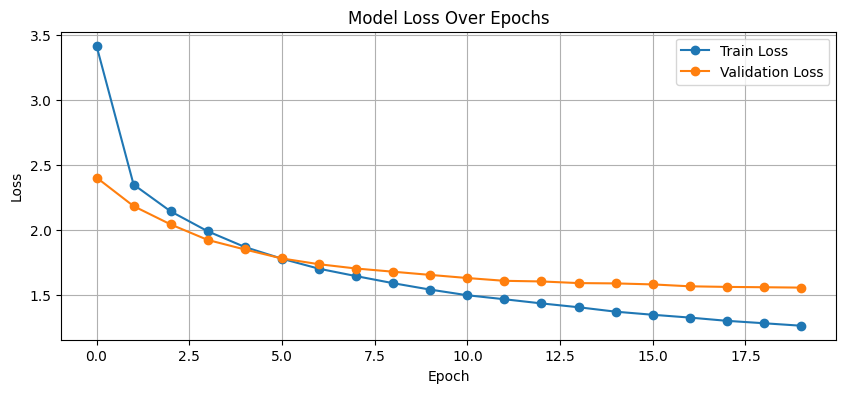

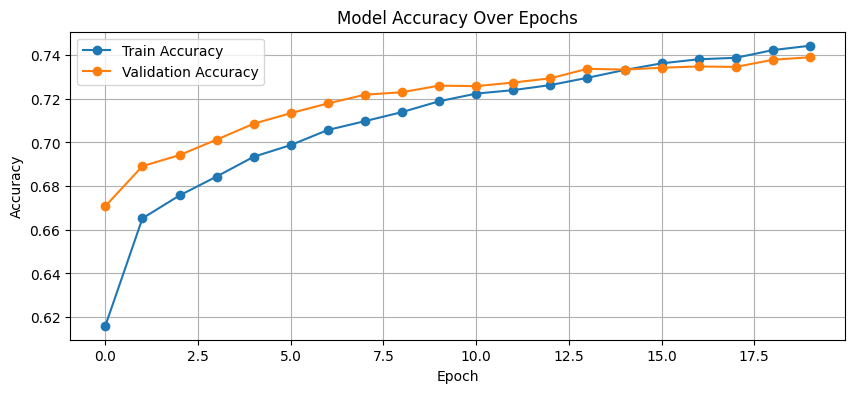

In [24]:
import matplotlib.pyplot as plt

# ------------------------
# Loss curves
# ------------------------
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------
# Accuracy curves
# ------------------------
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Save in native Keras format
model_save_path = "caption_generator_500.keras"
model.save(model_save_path)
print(f"✅ Model saved successfully at: {model_save_path}")

# Reload
from tensorflow.keras.models import load_model
loaded_model = load_model(model_save_path)
loaded_model.summary()

✅ Model saved successfully at: caption_generator_500.keras
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 caption_input (InputLayer)     [(None, 29)]         0           []                               
                                                                                                  
 image_features (InputLayer)    [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 29, 256)      578048      ['caption_input[0][0]']          
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['image_features[0][0]']         
                                 

In [26]:
import pickle

# ------------------------
# Save tokenizer
# ------------------------
tokenizer_path = "tokenizer_500.pkl"
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)
print(f"✅ Tokenizer saved at: {tokenizer_path}")

# ------------------------
# Save max caption length
# ------------------------
maxlen_path = "max_len_500.pkl"
with open(maxlen_path, "wb") as f:
    pickle.dump(max_len, f)
print(f"✅ Max caption length saved at: {maxlen_path}")

# ------------------------
# Verify by reloading
# ------------------------
with open(tokenizer_path, "rb") as f:
    tokenizer_loaded = pickle.load(f)
with open(maxlen_path, "rb") as f:
    max_len_loaded = pickle.load(f)

print("Tokenizer reloaded. Vocabulary size:", len(tokenizer_loaded.word_index))
print("Max caption length reloaded:", max_len_loaded)

✅ Tokenizer saved at: tokenizer_500.pkl
✅ Max caption length saved at: max_len_500.pkl
Tokenizer reloaded. Vocabulary size: 2257
Max caption length reloaded: 29


In [27]:
import os
os.listdir('.')  # Check current directory files


['.ipynb_checkpoints',
 'archive.zip',
 'caption_generator_500.keras',
 'caption_model_best.h5',
 'completed 500 image usig coploit.ipynb',
 'dataset',
 'end.py',
 'flickr8k_500',
 'max_len_500.pkl',
 'tokenizer.pkl',
 'tokenizer_500.pkl']

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def generate_caption(model, tokenizer, photo_feature, max_len=38, top_k=3, temperature=0.7, greedy=False):
    """
    Generate a caption for a given image feature using the trained model.

    Args:
        model: trained image-captioning model
        tokenizer: fitted tokenizer
        photo_feature: 2048-dim ResNet50 feature of the image
        max_len: maximum caption length
        top_k: number of top probable words to sample from (ignored if greedy=True)
        temperature: sampling temperature to control randomness
        greedy: if True, always pick the most probable word (deterministic)

    Returns:
        final_caption: generated caption string
    """
    in_text = "<start>"

    for _ in range(max_len):
        # Convert current text to integer sequence
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_len, padding='post')

        # Predict next word probabilities
        yhat = model.predict([photo_feature.reshape(1, -1), seq], verbose=0)[0]

        if greedy:
            # Deterministic greedy choice
            yhat_idx = np.argmax(yhat)
        else:
            # Apply temperature scaling
            yhat = np.log(yhat + 1e-10) / temperature
            yhat = np.exp(yhat) / np.sum(np.exp(yhat))

            # Sample from top_k predictions
            indices = np.argsort(yhat)[-top_k:]
            probs = yhat[indices] / np.sum(yhat[indices])
            yhat_idx = np.random.choice(indices, p=probs)

        # Map integer to word
        word = tokenizer.index_word.get(yhat_idx, None)
        if word is None or word == "<end>":
            break

        in_text += " " + word

    # ------------------------
    # Post-processing
    # ------------------------
    caption = in_text.replace("<start>", "").replace("<end>", "").strip()

    # Remove immediate repetition
    words = caption.split()
    clean = [words[0]] if words else []
    for w in words[1:]:
        if w != clean[-1]:
            clean.append(w)

    # Prevent excessive repetition of last 3 words
    unique_sentence = []
    for w in clean:
        if len(unique_sentence) < 2 or w not in unique_sentence[-3:]:
            unique_sentence.append(w)

    final_caption = " ".join(unique_sentence)
    return final_caption

In [29]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from pathlib import Path
import numpy as np
from tqdm import tqdm  # optional progress bar

# ------------------------
# Paths
# ------------------------
IMAGES_DIR = Path("./flickr8k_500/Images")
FEATURES_DIR = Path("./flickr8k_500/features")
FEATURES_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------
# Load InceptionV3 (pretrained, remove top layer)
# ------------------------
base_model = InceptionV3(weights="imagenet")
cnn_model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)  # 2048-dim features

# ------------------------
# Feature extraction function
# ------------------------
def extract_features(filename):
    try:
        img = load_img(filename, target_size=(299, 299))  # InceptionV3 input size
        img_arr = img_to_array(img)
        img_arr = np.expand_dims(img_arr, axis=0)
        img_arr = preprocess_input(img_arr)
        feature = cnn_model.predict(img_arr, verbose=0)
        return feature.reshape(2048,)  # flatten to 1D
    except Exception as e:
        print(f"⚠️ Failed to process {filename}: {e}")
        return None

# ------------------------
# Extract features for all 500 images
# ------------------------
for img_file in tqdm(list(IMAGES_DIR.glob("*.jpg")), desc="Extracting features"):
    feature_file = FEATURES_DIR / f"{img_file.stem}.npy"
    if not feature_file.exists():  # skip if already saved
        feature = extract_features(img_file)
        if feature is not None:
            np.save(feature_file, feature)

print("✅ Feature extraction complete for all available images!")

Extracting features: 100%|█████████████████████████████████████████████████████████| 968/968 [00:00<00:00, 5578.88it/s]

✅ Feature extraction complete for all available images!


In [30]:
import numpy as np

# ------------------------
# Load features from saved .npy files
# ------------------------
features = {}
for f in FEATURES_DIR.glob("*.npy"):
    try:
        features[f.stem + ".jpg"] = np.load(f)
    except Exception as e:
        print(f"⚠️ Failed to load {f.name}: {e}")

print("✅ Loaded features for", len(features), "images")

✅ Loaded features for 968 images


In [31]:
from pathlib import Path
import numpy as np

FEATURES_DIR = Path("./flickr8k_500/features")

# ------------------------
# Get all feature files
# ------------------------
feature_files = sorted(FEATURES_DIR.glob("*.npy"))  # sorted for consistency

if not feature_files:
    raise FileNotFoundError("⚠️ No feature files found in the directory!")

# ------------------------
# Load one image's features (first file)
# ------------------------
photo_feature = np.load(feature_files[0])

# ------------------------
# Generate caption
# ------------------------
caption = generate_caption(model, tokenizer, photo_feature, max_len=max_len)

print("✅ Caption generated successfully!")
print(f"Image: {feature_files[0].stem}.jpg")
print("Generated Caption:", caption)

✅ Caption generated successfully!
Image: 1001773457_577c3a7d70.jpg
Generated Caption: a black dog with a black dog in the air end



🖼️ Image: 3053813297_7ce5f87710.jpg
📜 Ground Truth Captions:
  1. A heavy set couple sitting in lawn chairs on the grass with a brown dog at their feet .
  2. An elderly man and woman are sitting on lawn chairs holding onto the leash of a brown dog .
  3. People sit in chairs at a park with a dog .
  4. People sitting in chairs while dog lies in grass
  5. Some people in a park with a dog and folding chairs .


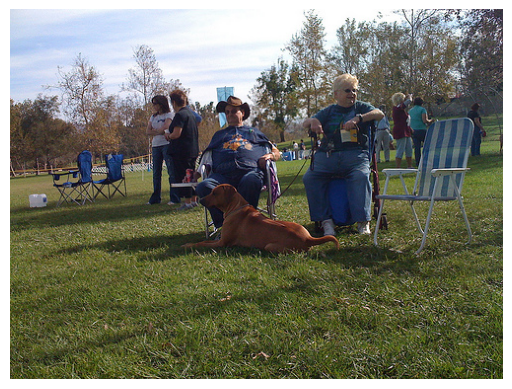

⚠️ No features available for this image.
🔊 Playing ground-truth caption audio...


Press Enter to view another image, or type 'exit' to quit:  



🖼️ Image: 1449370354_380c4123c9.jpg
📜 Ground Truth Captions:
  1. Kids running across the grass .
  2. Three young boys are running on grass .
  3. "Two boys , one wearing glasses , run across grass . Third child partially in shot ."
  4. two young boys running on a grassy field
  5. Young boys running on grass .


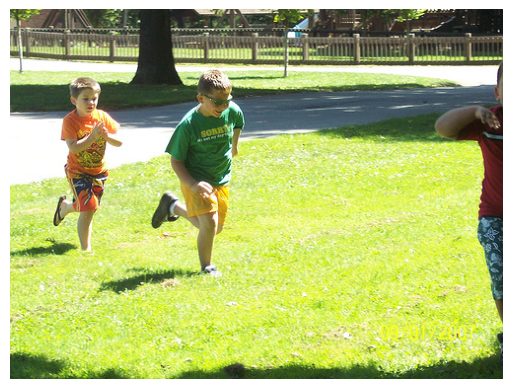

⚠️ No features available for this image.
🔊 Playing ground-truth caption audio...


Press Enter to view another image, or type 'exit' to quit:  



🖼️ Image: 2004674713_2883e63c67.jpg
📜 Ground Truth Captions:
  1. A brindle-coated dog is growling at a jumping brown dog with purple collar inside a park enclosure .
  2. A person is watching two puppies playing .
  3. A person standing behind two dogs interacting with one another .
  4. A person stands next to a snarling brown and black dog while a light brown dog stands up .
  5. "Two dogs , one brown , one gray play while a person in jeans stand near by ."


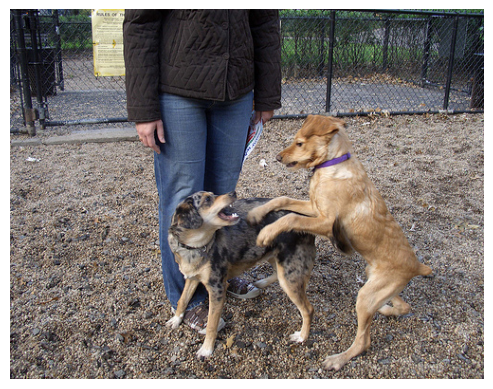

⚠️ No features available for this image.
🔊 Playing ground-truth caption audio...


Press Enter to view another image, or type 'exit' to quit:  



🖼️ Image: 489372715_ce52da796a.jpg
📜 Ground Truth Captions:
  1. A brown dog is shaking his head while standing on sand .
  2. A brown dog with large ears is shaking its self while standing on sand .
  3. An orange dog shakes his head very hard on the sand .
  4. a tan dog shaking its body
  5. The orange haired dog shook its head while standing on the beach .


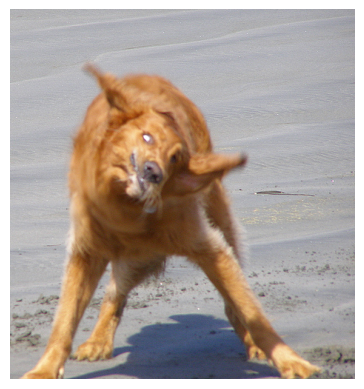

⚠️ No features available for this image.
🔊 Playing ground-truth caption audio...


Press Enter to view another image, or type 'exit' to quit:  exit


👋 Exiting viewer.


In [46]:
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from collections import defaultdict
from gtts import gTTS
from IPython.display import Audio, display
import os
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ------------------------
# Paths for the 500-image subset
# ------------------------
OUT_DIR = Path("./flickr8k_500")
OUT_IMAGES = OUT_DIR / "Images"
CAPTIONS_FILE = OUT_DIR / "captions_500.txt"

# ------------------------
# Load ground-truth captions
# ------------------------
captions = defaultdict(list)
with open(CAPTIONS_FILE, "r", encoding="utf-8") as f:
    for line in f:
        if "\t" in line:
            img, cap = line.strip().split("\t", 1)
            captions[img].append(cap.strip())

# ------------------------
# Caption generation functions
# ------------------------
def generate_caption(model, tokenizer, photo_feature, max_len=15, top_k=5, temperature=0.8, greedy=False):
    in_text = "<start>"
    for _ in range(max_len):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_len)

        yhat_probs = model.predict([photo_feature.reshape(1, -1), sequence], verbose=0)[0]

        if greedy:
            yhat = np.argmax(yhat_probs)
        else:
            yhat_probs = np.log(yhat_probs + 1e-10) / temperature
            yhat_probs = np.exp(yhat_probs) / np.sum(np.exp(yhat_probs))
            indices = np.argsort(yhat_probs)[-top_k:]
            probs = yhat_probs[indices] / np.sum(yhat_probs[indices])
            yhat = np.random.choice(indices, p=probs)

        word = tokenizer.index_word.get(yhat, None)
        if word is None or word == "<end>":
            break
        in_text += " " + word

    caption = in_text.replace("<start>", "").replace("end", "").strip()
    words = caption.split()
    cleaned = [words[0]] if words else []
    for i in range(1, len(words)):
        if words[i] != words[i - 1]:
            cleaned.append(words[i])
    return " ".join(cleaned)

def is_valid_caption(caption):
    banned = {"dog", "dogs"}
    return caption and len(caption.split()) >= 4 and not any(w in caption.lower().split() for w in banned)

def pick_best_caption(*captions):
    for cap in captions:
        if is_valid_caption(cap):
            return cap
    return None

# ------------------------
# Interactive loop
# ------------------------
while True:
    sample_img = random.choice(list(captions.keys()))
    img_path = OUT_IMAGES / sample_img

    if not img_path.exists():
        print(f"⚠️ Image not found: {sample_img}")
        continue

    print("\n" + "="*60)
    print(f"🖼️ Image: {sample_img}")

    # Show ground-truth captions
    print("📜 Ground Truth Captions:")
    for i, cap in enumerate(captions[sample_img], 1):
        print(f"  {i}. {cap}")

    # Show image
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    # Generate model captions if features exist
    if sample_img in image_features:
        photo_feature = image_features[sample_img]
        caption_sampled = generate_caption(model, tokenizer, photo_feature, max_len=15, top_k=5, temperature=0.8)
        caption_greedy = generate_caption(model, tokenizer, photo_feature, max_len=15, greedy=True)

        print("🎲 Sampled Caption:", caption_sampled if is_valid_caption(caption_sampled) else "⚠️ Unreliable caption.")
        print("🔍 Greedy Caption:", caption_greedy if is_valid_caption(caption_greedy) else "⚠️ Unreliable caption.")

        # Pick best caption for audio (model first, fallback to human)
        caption_for_audio = pick_best_caption(caption_greedy, caption_sampled)
        if not caption_for_audio and captions[sample_img]:
            caption_for_audio = captions[sample_img][0]

        # 🔊 Play model caption audio
        if caption_for_audio:
            audio_file = "temp_model_caption.mp3"
            tts = gTTS(text=caption_for_audio, lang="en")
            tts.save(audio_file)
            print("🔊 Playing model caption audio...")
            display(Audio(audio_file, autoplay=True))
            os.remove(audio_file)

    else:
        print("⚠️ No features available for this image.")

    # 🔊 Always play ground-truth caption audio (first one)
    if captions[sample_img]:
        gt_caption = captions[sample_img][0]
        audio_file = "temp_gt_caption.mp3"
        tts = gTTS(text=gt_caption, lang="en")
        tts.save(audio_file)
        print("🔊 Playing ground-truth caption audio...")
        display(Audio(audio_file, autoplay=True))
        os.remove(audio_file)

    # User interaction
    user_input = input("Press Enter to view another image, or type 'exit' to quit: ")
    if user_input.lower() == "exit":
        print("👋 Exiting viewer.")
        break

In [1]:
import tensorflow as tf
print(tf.__version__)


2.10.0


In [38]:
# for frontend 

In [ ]:
with open("tokenizer_500_fixed.pkl", "wb") as f:
    pickle.dump(tok, f)


In [ ]:
tokenizer, rev_index = load_tokenizer("tokenizer_500_fixed.pkl")

start_token = tokenizer.word_index["startseq"]
end_token   = tokenizer.word_index["endseq"]
